## Import Libraries

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
#from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
import pandas as pd
data=pd.read_csv('agnews_train(entropy).csv')
data.head()

,Class Index,text,label1,label2,label3,label4,label5,label6,label7,label8,...,sci6,world7,sports7,business7,sci7,entropy_world,entropy_sports,entropy_business,entropy_sci,entropy
0,3,Title: Wall St. Bears Claw Back Into the Black...,topic: business,business,topic: business,true.,FALSE,true.,false. this news title and description belongs...,business,...,0,1,0,1,0,0.863121,0.0,0.0,0.000000,0.215780
1,3,Title: Carlyle Looks Toward Commercial Aerospa...,business,business,topic: business,true.,false.,TRUE,FALSE,business,...,0,1,0,1,0,0.863121,0.0,0.0,0.000000,0.215780
2,3,Title: Oil and Economy Cloud Stocks' Outlook (...,topic: business,business,"the topic of this news article is ""business"".",TRUE,false.,true.,FALSE,"the topic is ""business"".",...,0,1,0,1,0,0.863121,0.0,0.0,0.000000,0.215780
3,3,Title: Iraq Halts Oil Exports from Main Southe...,business,business,business,TRUE,false. the news title and description belong t...,true.,TRUE,"the topic is ""business"".",...,0,1,0,1,0,0.863121,0.0,0.0,0.591673,0.363698
4,3,"Title: Oil prices soar to all-time record, pos...",business,business,topic: business,true.,FALSE,TRUE,TRUE,business,...,0,1,0,1,0,0.863121,0.0,0.0,0.591673,0.363698


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Class Index       1154 non-null   int64  
 1   text              1154 non-null   object 
 2   label1            1154 non-null   object 
 3   label2            1154 non-null   object 
 4   label3            1154 non-null   object 
 5   label4            1154 non-null   object 
 6   label5            1154 non-null   object 
 7   label6            1154 non-null   object 
 8   label7            1154 non-null   object 
 9   label8            1154 non-null   object 
 10  label9            1154 non-null   object 
 11  label10           1154 non-null   object 
 12  label11           1154 non-null   object 
 13  label12           1154 non-null   object 
 14  label13           1154 non-null   object 
 15  4label1           1154 non-null   float64
 16  5label1           1154 non-null   float64


In [ ]:
data['gold_label']=data['Class Index']
def calculate_alignment(threshold, df_input):
  df_low=df_input[df_input['entropy']<=threshold]
  print(df_low.shape[0])
  df_low['world_gold']=df_low['gold_label'].apply(lambda x:1 if x==1 else 0)
  df_low['gold_sports']=df_low['gold_label'].apply(lambda x:1 if x==2 else 0)
  df_low['gold_business']=df_low['gold_label'].apply(lambda x:1 if x==3 else 0)
  df_low['gold_sci']=df_low['gold_label'].apply(lambda x:1 if x==4 else 0)
  df_low_correct1=df_low[df_low['MV_world']==df_low['world_gold']]
  df_low_correct2=df_low[df_low['MV_sports']==df_low['gold_sports']]
  df_low_correct3=df_low[df_low['MV_business']==df_low['gold_business']]
  df_low_correct4=df_low[df_low['MV_sci']==df_low['gold_sci']]
  return (df_low_correct1.shape[0]+df_low_correct2.shape[0]+df_low_correct3.shape[0]+df_low_correct4.shape[0])/4/df_low.shape[0]

141
266
832
1064
1146
1154


<ipython-input-5-cc88c7172cb6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['world_gold']=df_low['gold_label'].apply(lambda x:1 if x==1 else 0)
<ipython-input-5-cc88c7172cb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low['gold_sports']=df_low['gold_label'].apply(lambda x:1 if x==2 else 0)
<ipython-input-5-cc88c7172cb6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

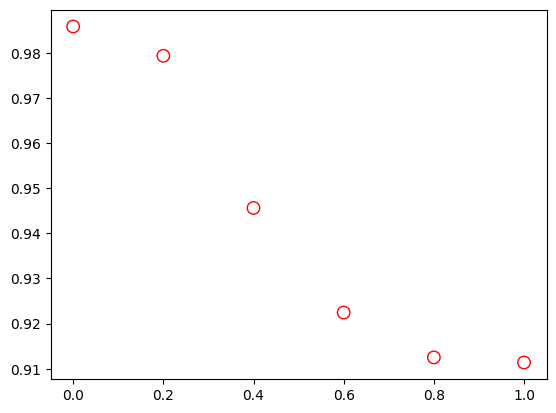

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [0, 0.2, 0.4, 0.6, 0.8, 1]
y = [calculate_alignment(i, data) for i in x]

plt.scatter(x, y, s=80, facecolors='none', edgecolors='r')
plt.show()

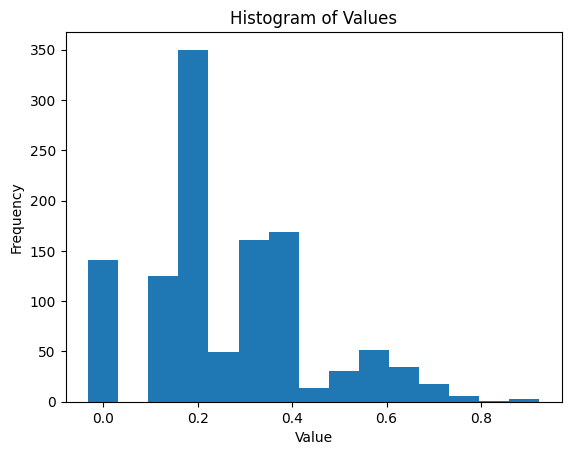

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.hist(data['entropy'], bins=15, align='left')

# Add axis labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
# Display the plot
plt.show()

In [ ]:
df=data
df_high=df[df['entropy']>1.4]
df_high.shape[0]

92

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      918 non-null    int64  
 1   text            918 non-null    object 
 2   humor           918 non-null    bool   
 3   prompt1         918 non-null    object 
 4   prompt2         918 non-null    object 
 5   prompt3         918 non-null    object 
 6   prompt4         918 non-null    object 
 7   prompt5         918 non-null    object 
 8   prompt6         918 non-null    object 
 9   prompt7         918 non-null    object 
 10  prompt8         918 non-null    object 
 11  prompt9         918 non-null    object 
 12  label1          918 non-null    object 
 13  label2          918 non-null    object 
 14  label3          918 non-null    object 
 15  label4          918 non-null    object 
 16  label5          918 non-null    object 
 17  label6          918 non-null    obj

In [ ]:
df_high['text'].tolist()[:10]

['Martha stewart tweets hideous food photo, twitter responds accordingly',
 'Donald trump has found something mysterious for rudy giuliani to do',
 "How donald trump and ted cruz's love affair is all relationships",
 'Alec baldwin and wife hilaria welcome another baby boy',
 'Watch: former british open champ makes embarrassing putting fail',
 'Interesting fact: by the year 2020 all actors on american tv shows will be australian.',
 'On set with paul mitchell: from our network',
 "My sons ebola joke what do africans have for breakfast? ebola cereal :) (be kind,he's only 14 lol)",
 'How do you know if someone is using recursion?',
 "Valentine's dinner stress: 4 things not to worry about"]

In [ ]:
df_low=data[data['entropy']<0.3]
df_low.shape[0]

665

In [ ]:
sum(df_low['length'].tolist())

0

In [ ]:
df_low=data[data['entropy']<1]
print(df_low.shape[0])
df=df_low
df['length1']=df['prompt1'].apply(lambda x:len(x.split()))
df['length2']=df['prompt2'].apply(lambda x:len(x.split()))
df['length3']=df['prompt3'].apply(lambda x:len(x.split()))
df['length4']=df['prompt4'].apply(lambda x:len(x.split()))
df['length5']=df['prompt5'].apply(lambda x:len(x.split()))
df['length6']=df['prompt6'].apply(lambda x:len(x.split()))
df['length7']=df['prompt7'].apply(lambda x:len(x.split()))
df['length8']=df['prompt8'].apply(lambda x:len(x.split()))
df['length9']=df['prompt9'].apply(lambda x:len(x.split()))
df['length10']=df['prompt10'].apply(lambda x:len(x.split()))
df['length11']=df['prompt11'].apply(lambda x:len(x.split()))
df['length12']=df['prompt12'].apply(lambda x:len(x.split()))
df['length13']=df['prompt13'].apply(lambda x:len(x.split()))
df['length']=df['length1']+df['length2']+df['length3']+df['length4']+df['length5']+df['length6']+df['length7']+df['length8']+df['length9']+df['length10']+df['length11']+df['length12']+df['length13']
sum(df['length'].tolist())

1154


989297

In [ ]:
df_low['text'].tolist()[:10]

['Study finds strong link between zika and guillain-barre syndrome',
 "Reflections from davos: leaders deliberate what's next for climate action after paris deal",
 'What do you call an explanation of an asian cooking show? a wok-through.',
 'Why did little miss muffet have gps on her tuffet? to keep her from losing her whey.',
 'Oscars 2016 red carpet: all the stunning looks from the academy awards',
 'What do chicken families do on saturday afternoon? they go on peck-nics !',
 "My friend is dealing with a really severe viagra addiction. he's having a hard time with it.",
 'Did you hear about the flying german pancakes in ww2? they were in the luftwaffle!',
 "What's black and always in the back of a police car? the seat.",
 "Veterinarian accused of shooting neighbors' dog in the head"]

In [ ]:
df_low['humor'].tolist()[:10]

[False, False, True, True, False, True, True, True, True, False]

In [ ]:
# count the unique values in the 'fruit' column
counts = data['entropy'].value_counts()

# print the unique values and their count
for index, count in counts.iteritems():
    print(f"{index}: {count}")

0.2157801421416577: 350
0.3636983367872396: 161
0.4315602842833155: 157
-0.0: 141
0.1479181946455818: 125
0.2958363892911637: 49
0.6100053707958025: 27
0.5794784789288974: 24
0.5116165314328215: 23
0.6778673182918784: 22
0.7579235654413844: 11
0.4620871761502206: 10
0.5421434232997266: 8
0.3942252286541448: 6
0.4437545839367456: 6
0.6473404264249732: 5
0.6405322626627077: 5
0.8257855129374603: 4
0.4926140680171257: 4
0.6595347260784034: 3
0.7083942101587836: 3
0.7273966735744792: 2
0.9547012441673464: 1
0.7083942101587835: 1
0.8868392966712706: 1
0.8936474604335362: 1
0.7884504573082896: 1
0.7389211020256886: 1
0.7952586210705551: 1
0.9241743523004412: 1


<ipython-input-6-707faf383544>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, count in counts.iteritems():


In [ ]:
import pandas as pd
df=data
df=df.sort_values(by='entropy', ignore_index=True)
# Assuming your dataframe is called 'df'
total_rows = df.shape[0]
num_rows_20_percent = int(total_rows * 0.8) #can change this to 0.2, 0.4, 0.6, 0.8


df['allocate'] = 0  # Initialize the new column with 0
df.loc[:num_rows_20_percent-1, 'allocate'] = 1  # Assign 1 to the first 20% of rows

df.head()

,Class Index,text,label1,label2,label3,label4,label5,label6,label7,label8,...,world7,sports7,business7,sci7,entropy_world,entropy_sports,entropy_business,entropy_sci,entropy,allocate
0,1,Title: Pope Struggles Through Mass at Lourdes ...,world,world,topic: world,TRUE,false.,false.,false.,world,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1
1,1,Title: China Typhoon Death Toll Rises to 164 (...,world,world,topic: world,TRUE,false.,false.,false.,world,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1
2,1,Title: Wanted: Sleeping Space for Protesters. ...,topic: world,topic: world,topic: world,true.,false.,false.,false.,"the topic is ""world"".",...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1
3,1,Title: Clashes persist in South Ossetia Descri...,world,world,topic: world,true.,false.,false.,false.,world,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1
4,1,Title: U.S. Awaits Judgment on Venezuela Votin...,world,world,topic: world,true.,false.,false.,false.,world,...,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
#combined
df['gold_label']=df['Class Index']
world=[]
sports=[]
business=[]
sci=[]
chatgpt_count=0

for index, row in df.iterrows():
    if row['allocate']==1:
      world.append(row['MV_world'])
      sports.append(row['MV_sports'])
      business.append(row['MV_business'])
      sci.append(row['MV_sci'])
    else:
      if row['gold_label']==1:
        world.append(1)
        sports.append(0)
        business.append(0)
        sci.append(0)
      elif row['gold_label']==2:
        world.append(0)
        sports.append(1)
        business.append(0)
        sci.append(0)
      elif row['gold_label']==3:
        world.append(0)
        sports.append(0)
        business.append(1)
        sci.append(0)
      elif row['gold_label']==4:
        world.append(0)
        sports.append(0)
        business.append(0)
        sci.append(1)
df['world']=world
df['sports']=sports
df['business']=business
df['sci']=sci
df.head()

,Class Index,text,label1,label2,label3,label4,label5,label6,label7,label8,...,entropy_sports,entropy_business,entropy_sci,entropy,allocate,gold_label,world,sports,business,sci
0,1,Title: Pope Struggles Through Mass at Lourdes ...,world,world,topic: world,TRUE,false.,false.,false.,world,...,0.0,0.0,0.0,0.0,1,1,1,0,0,0
1,1,Title: China Typhoon Death Toll Rises to 164 (...,world,world,topic: world,TRUE,false.,false.,false.,world,...,0.0,0.0,0.0,0.0,1,1,1,0,0,0
2,1,Title: Wanted: Sleeping Space for Protesters. ...,topic: world,topic: world,topic: world,true.,false.,false.,false.,"the topic is ""world"".",...,0.0,0.0,0.0,0.0,1,1,1,0,0,0
3,1,Title: Clashes persist in South Ossetia Descri...,world,world,topic: world,true.,false.,false.,false.,world,...,0.0,0.0,0.0,0.0,1,1,1,0,0,0
4,1,Title: U.S. Awaits Judgment on Venezuela Votin...,world,world,topic: world,true.,false.,false.,false.,world,...,0.0,0.0,0.0,0.0,1,1,1,0,0,0


## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [ ]:
#df = data #jigsaw-toxic-comment-classification-challenge

In [ ]:
#combined
cols = df.columns
label_cols = list(cols[56:60])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['world', 'sports', 'business', 'sci']


In [ ]:
print('Count of 1 per label: \n', df[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', df[label_cols].eq(0).sum())

Count of 1 per label: 
 world       268
sports      266
business    356
sci         265
dtype: int64 

Count of 0 per label: 
 world       886
sports      888
business    798
sci         889
dtype: int64


In [ ]:
#df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [ ]:
df=df.drop(659)

In [ ]:
df=df.drop(1093)
df=df.drop(1043)

In [ ]:
df['one_hot_labels'] = list(df[label_cols].values)
df.head()

,Class Index,text,label1,label2,label3,label4,label5,label6,label7,label8,...,entropy_business,entropy_sci,entropy,allocate,gold_label,world,sports,business,sci,one_hot_labels
0,1,Title: Pope Struggles Through Mass at Lourdes ...,world,world,topic: world,TRUE,false.,false.,false.,world,...,0.0,0.0,0.0,1,1,1,0,0,0,"[1, 0, 0, 0]"
1,1,Title: China Typhoon Death Toll Rises to 164 (...,world,world,topic: world,TRUE,false.,false.,false.,world,...,0.0,0.0,0.0,1,1,1,0,0,0,"[1, 0, 0, 0]"
2,1,Title: Wanted: Sleeping Space for Protesters. ...,topic: world,topic: world,topic: world,true.,false.,false.,false.,"the topic is ""world"".",...,0.0,0.0,0.0,1,1,1,0,0,0,"[1, 0, 0, 0]"
3,1,Title: Clashes persist in South Ossetia Descri...,world,world,topic: world,true.,false.,false.,false.,world,...,0.0,0.0,0.0,1,1,1,0,0,0,"[1, 0, 0, 0]"
4,1,Title: U.S. Awaits Judgment on Venezuela Votin...,world,world,topic: world,true.,false.,false.,false.,world,...,0.0,0.0,0.0,1,1,1,0,0,0,"[1, 0, 0, 0]"


In [ ]:
labels = list(df.one_hot_labels.values)
comments = list(df.text.values)

Load the pretrained tokenizer that corresponds to your choice in model. e.g.,

```
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In order to avoid memory issues with Google Colab, I enforce a max_length of 100 tokens. Note that some sentences may not adequately represent each label because of this.

In [ ]:
from transformers import RobertaTokenizer
max_length = 100
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [ ]:
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
#token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [ ]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
#one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [ ]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=20, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
#train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
#train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
#validation_token_types = torch.tensor(validation_token_types)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

Load the appropriate model below, each model already contains a single dense layer for classification on top.



```
BERT:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

XLNet:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

RoBERTa:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
```



In [ ]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
from transformers import RobertaForSequenceClassification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should pr

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [ ]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
from transformers import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5 ,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [ ]:
def is_max(array):
  max_val=max(array)
  res=[i==max_val for i in array]
  return res

In [ ]:
# Store our loss and accuracy for plotting - 0
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 10

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  #threshold = 0.30
  #pred_bools = [pl>threshold for pl in pred_labels]
  #print(pred_labels)
  #max_val = max(pred_labels)
  pred_bools = [is_max(arr) for arr in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.4049999876664235


Epoch:  10%|█         | 1/10 [00:17<02:39, 17.69s/it]

F1 Validation Accuracy:  92.24137931034483
Flat Validation Accuracy:  92.24137931034483
Train loss: 0.12892476784495208


Epoch:  20%|██        | 2/10 [00:35<02:23, 17.95s/it]

F1 Validation Accuracy:  87.06896551724138
Flat Validation Accuracy:  87.06896551724138
Train loss: 0.08471723012626171


Epoch:  30%|███       | 3/10 [00:54<02:08, 18.29s/it]

F1 Validation Accuracy:  87.93103448275863
Flat Validation Accuracy:  87.93103448275862
Train loss: 0.05749459808262495


Epoch:  40%|████      | 4/10 [01:13<01:51, 18.56s/it]

F1 Validation Accuracy:  85.34482758620689
Flat Validation Accuracy:  85.34482758620689
Train loss: 0.045284357924874015


Epoch:  50%|█████     | 5/10 [01:32<01:33, 18.62s/it]

F1 Validation Accuracy:  86.20689655172413
Flat Validation Accuracy:  86.20689655172413
Train loss: 0.03986267308489634


Epoch:  60%|██████    | 6/10 [01:50<01:14, 18.60s/it]

F1 Validation Accuracy:  88.79310344827587
Flat Validation Accuracy:  88.79310344827587
Train loss: 0.033958851173520085


Epoch:  70%|███████   | 7/10 [02:09<00:55, 18.59s/it]

F1 Validation Accuracy:  87.06896551724138
Flat Validation Accuracy:  87.06896551724138
Train loss: 0.02452939413487911


Epoch:  80%|████████  | 8/10 [02:28<00:37, 18.63s/it]

F1 Validation Accuracy:  89.65517241379311
Flat Validation Accuracy:  89.65517241379311
Train loss: 0.0302388100240093


Epoch:  90%|█████████ | 9/10 [02:46<00:18, 18.67s/it]

F1 Validation Accuracy:  87.93103448275863
Flat Validation Accuracy:  87.93103448275862
Train loss: 0.022198500957053443


Epoch: 100%|██████████| 10/10 [03:05<00:00, 18.55s/it]

F1 Validation Accuracy:  87.06896551724138
Flat Validation Accuracy:  87.06896551724138


In [ ]:
# Store our loss and accuracy for plotting - 0.2
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  #threshold = 0.30
  #pred_bools = [pl>threshold for pl in pred_labels]
  #print(pred_labels)
  #max_val = max(pred_labels)
  pred_bools = [is_max(arr) for arr in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.015534048477331032


Epoch:  20%|██        | 1/5 [00:18<01:15, 18.83s/it]

F1 Validation Accuracy:  87.93103448275863
Flat Validation Accuracy:  87.93103448275862
Train loss: 0.020301148610619397


Epoch:  40%|████      | 2/5 [00:38<00:57, 19.16s/it]

F1 Validation Accuracy:  86.20689655172413
Flat Validation Accuracy:  86.20689655172413
Train loss: 0.01689189364417241


Epoch:  60%|██████    | 3/5 [00:56<00:37, 18.96s/it]

F1 Validation Accuracy:  86.20689655172413
Flat Validation Accuracy:  86.20689655172413
Train loss: 0.01650217930571391


Epoch:  80%|████████  | 4/5 [01:15<00:18, 18.75s/it]

F1 Validation Accuracy:  87.93103448275863
Flat Validation Accuracy:  87.93103448275862
Train loss: 0.016973170107946946


Epoch: 100%|██████████| 5/5 [01:33<00:00, 18.77s/it]

F1 Validation Accuracy:  87.93103448275863
Flat Validation Accuracy:  87.93103448275862


## Load and Preprocess Test Data

In [ ]:
test_df = pd.read_csv('agnews_test.csv')
#test_labels_df = pd.read_csv('test_labels.csv')
#test_df = test_df.merge(test_labels_df, on='id', how='left')
# test_df['text']=test_df['sentence']
test_df['world']=test_df['gold_label'].apply(lambda x:1 if x==1 else 0)
test_df['sports']=test_df['gold_label'].apply(lambda x:1 if x==2 else 0)
test_df['business']=test_df['gold_label'].apply(lambda x:1 if x==3 else 0)
test_df['sci']=test_df['gold_label'].apply(lambda x:1 if x==4 else 0)
#print('Null values: ', test_df.isnull().values.any()) #should not be any null sentences or labels
#print('Same columns between train and test: ', label_cols == test_label_cols) #columns should be the same
test_df.tail()

,Class Index,Title,Description,text,gold_label,world,sports,business,sci
495,2,Pressure points,ATHENS -- The booing went on for nearly 10 min...,Title: Pressure points Description: ATHENS -- ...,2,0,1,0,0
496,3,Unions protest as overtime rules take effect,WASHINGTON -- Hundreds of workers rallied on t...,Title: Unions protest as overtime rules take e...,3,0,0,1,0
497,1,Serb denies siege terror charges,A Bosnian Serb general accused of organising t...,Title: Serb denies siege terror charges Descri...,1,1,0,0,0
498,2,11th-hour highlights too late,NBC's prime-time Olympic coverage is taped and...,Title: 11th-hour highlights too late Descripti...,2,0,1,0,0
499,4,No IE? No Can See,One thing that #39;s always irritated those wh...,Title: No IE? No Can See Description: One thin...,4,0,0,0,1


In [ ]:
test_label_cols = list(test_df.columns[5:])
test_label_cols

['world', 'sports', 'business', 'sci']

In [ ]:
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
test_df['one_hot_labels'] = list(test_df[test_label_cols].values)
test_df.head()

,Class Index,Title,Description,text,gold_label,world,sports,business,sci,one_hot_labels
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Title: Fears for T N pension after talks Descr...,3,0,0,1,0,"[0, 0, 1, 0]"
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",Title: The Race is On: Second Private Team Set...,4,0,0,0,1,"[0, 0, 0, 1]"
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Title: Ky. Company Wins Grant to Study Peptide...,4,0,0,0,1,"[0, 0, 0, 1]"
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,Title: Prediction Unit Helps Forecast Wildfire...,4,0,0,0,1,"[0, 0, 0, 1]"
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,Title: Calif. Aims to Limit Farm-Related Smog ...,4,0,0,0,1,"[0, 0, 0, 1]"


In [ ]:
# Gathering input data
test_labels = list(test_df.one_hot_labels.values)
test_comments = list(test_df.text.values)

In [ ]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
#test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
#test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
#test_data = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [ ]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  #b_input_ids, b_input_mask = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

In [ ]:
pred_labels[:10]

[array([0.0045191 , 0.12284625, 0.78677535], dtype=float32),
 array([0.9635983 , 0.04758941, 0.00145089], dtype=float32),
 array([0.00207093, 0.01049966, 0.99107623], dtype=float32),
 array([0.01098563, 0.99250317, 0.00175095], dtype=float32),
 array([0.9887567 , 0.01733083, 0.00118418], dtype=float32),
 array([0.00506789, 0.00214649, 0.997235  ], dtype=float32),
 array([0.9978714 , 0.00287712, 0.00215554], dtype=float32),
 array([0.00341052, 0.996572  , 0.00284842], dtype=float32),
 array([0.9862281 , 0.00255858, 0.01361227], dtype=float32),
 array([0.10106141, 0.09945446, 0.10647077], dtype=float32)]

In [ ]:
is_max(pred_labels[0])

[False, False, True]

In [ ]:
len(true_labels)

10000

We need to threshold our sigmoid function outputs which range from [0, 1]. Below I use 0.50 as a threshold.

In [ ]:
#combined - 0
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Accuracy:  0.882
Test Flat Accuracy:  0.882 

              precision    recall  f1-score   support

       world       0.81      0.93      0.86       122
      sports       0.97      0.92      0.94       145
    business       0.83      0.82      0.82       106
         sci       0.92      0.85      0.88       127

   micro avg       0.88      0.88      0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500
 samples avg       0.88      0.88      0.88       500



In [ ]:
#combined - 0.2
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8838277474132114
Micro Test F1 Accuracy:  0.89
Weighted Test F1 Accuracy:  0.8899179032409382
Test Flat Accuracy:  0.89 

              precision    recall  f1-score   support

       world       0.87      0.89      0.88       122
      sports       0.97      0.95      0.96       145
    business       0.82      0.79      0.80       106
         sci       0.89      0.90      0.89       127

   micro avg       0.89      0.89      0.89       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.89      0.89      0.89       500
 samples avg       0.89      0.89      0.89       500



In [ ]:
#combined - 0.4
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8815924915510439
Micro Test F1 Accuracy:  0.886
Weighted Test F1 Accuracy:  0.886853086237362
Test Flat Accuracy:  0.886 

              precision    recall  f1-score   support

       world       0.92      0.85      0.89       122
      sports       0.95      0.97      0.96       145
    business       0.75      0.90      0.82       106
         sci       0.92      0.82      0.87       127

   micro avg       0.89      0.89      0.89       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.89      0.89       500
 samples avg       0.89      0.89      0.89       500



In [ ]:
#combined - 0.6
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8742179386308181
Micro Test F1 Accuracy:  0.88
Weighted Test F1 Accuracy:  0.8805429776426997
Test Flat Accuracy:  0.88 

              precision    recall  f1-score   support

       world       0.85      0.87      0.86       122
      sports       0.95      0.97      0.96       145
    business       0.77      0.83      0.80       106
         sci       0.93      0.83      0.88       127

   micro avg       0.88      0.88      0.88       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.88      0.88       500
 samples avg       0.88      0.88      0.88       500



In [ ]:
#combined - 0.8
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8398007293268176
Micro Test F1 Accuracy:  0.848
Weighted Test F1 Accuracy:  0.8472770593659139
Test Flat Accuracy:  0.848 

              precision    recall  f1-score   support

       world       0.83      0.84      0.84       122
      sports       0.94      0.99      0.96       145
    business       0.69      0.86      0.77       106
         sci       0.94      0.69      0.79       127

   micro avg       0.85      0.85      0.85       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.86      0.85      0.85       500
 samples avg       0.85      0.85      0.85       500



In [ ]:
#combined - 1
pred_bools = [is_max(pl) for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Macro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='macro'))
print('Micro Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='micro'))
print('Weighted Test F1 Accuracy: ', f1_score(true_bools, pred_bools,average='weighted'))
print('Test Flat Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Macro Test F1 Accuracy:  0.8265653472085007
Micro Test F1 Accuracy:  0.836
Weighted Test F1 Accuracy:  0.8343256624733804
Test Flat Accuracy:  0.836 

              precision    recall  f1-score   support

       world       0.86      0.84      0.85       122
      sports       0.94      0.99      0.96       145
    business       0.65      0.90      0.75       106
         sci       0.94      0.61      0.74       127

   micro avg       0.84      0.84      0.84       500
   macro avg       0.85      0.83      0.83       500
weighted avg       0.86      0.84      0.83       500
 samples avg       0.84      0.84      0.84       500



# Significance Testing

In [ ]:
import random

size = 500
proportion_of_ones = 0.847

# Calculate the number of 1s based on the desired proportion
num_ones = int(size * proportion_of_ones)

# Create the list with num_ones 1s and (size - num_ones) 0s
my_list = random.choices([0, 1], k=num_ones) + [0] * (size - num_ones)

# Shuffle the list to randomize the order
random.shuffle(my_list)

import statistics


std_dev = statistics.stdev(my_list)

print(std_dev)

0.49873185875164194


In [ ]:
import random

size = 500
proportion_of_ones = 0.818

# Calculate the number of 1s based on the desired proportion
num_ones = int(size * proportion_of_ones)

# Create the list with num_ones 1s and (size - num_ones) 0s
my_list = random.choices([0, 1], k=num_ones) + [0] * (size - num_ones)

# Shuffle the list to randomize the order
random.shuffle(my_list)

import statistics


std_dev = statistics.stdev(my_list)

print(std_dev)

0.48823841871263474


In [ ]:
#0.2
import scipy.stats as stats

t_statistic, p_value = stats.ttest_ind_from_stats(
    0.8838277474132114, 0.49662726305543786, 500, 0.8793896106883861, 0.49638371607776816, 500, alternative='greater'
)

if p_value < 0.1:
    print("The mean of Group A is significantly higher than Group B.")
else:
    print("There is no significant difference between the means of Group A and Group B.")

There is no significant difference between the means of Group A and Group B.


In [ ]:
#0.4
import scipy.stats as stats

t_statistic, p_value = stats.ttest_ind_from_stats(
    0.8815924915510439, 0.4949889171043249, 500, 0.8583741668153195, 0.48868561187588594, 500, alternative='greater'
)

if p_value < 0.1:
    print("The mean of Group A is significantly higher than Group B.")
else:
    print("There is no significant difference between the means of Group A and Group B.")

There is no significant difference between the means of Group A and Group B.


In [ ]:
#0.6
import scipy.stats as stats

t_statistic, p_value = stats.ttest_ind_from_stats(
    0.8742179386308181, 0.49157633648211585, 500, 0.7980504439471048, 0.49038858257900714, 500, alternative='greater'
)

if p_value < 0.05:
    print("The mean of Group A is significantly higher than Group B.")
else:
    print("There is no significant difference between the means of Group A and Group B.")
p_value

The mean of Group A is significantly higher than Group B.


0.007171316416932223

In [ ]:
#0.8
import scipy.stats as stats

t_statistic, p_value = stats.ttest_ind_from_stats(
    0.847, 0.49873185875164194, 500, 0.818, 0.48823841871263474, 500, alternative='greater'
)

if p_value < 0.05:
    print("The mean of Group A is significantly higher than Group B.")
else:
    print("There is no significant difference between the means of Group A and Group B.")
p_value

There is no significant difference between the means of Group A and Group B.


0.1765271293296073